In [1]:
!pip install tensorflow==2.17.0 | tail -n 1
!pip install numpy==1.26.0 | tail -n 1
!pip install scikit-learn==1.5.1  | tail -n 1
!pip install matplotlib==3.9.2  | tail -n 1

'tail' is not recognized as an internal or external command,
operable program or batch file.
'tail' is not recognized as an internal or external command,
operable program or batch file.
'tail' is not recognized as an internal or external command,
operable program or batch file.
'tail' is not recognized as an internal or external command,
operable program or batch file.


In [2]:
import platform
print(platform.python_version())

3.10.9


In [3]:
import numpy as np
import os
# import random, shutil
import glob


from matplotlib import pyplot as plt
from matplotlib import pyplot
from matplotlib.image import imread

# from os import makedirs,listdir
# from shutil import copyfile
# from random import seed
# from random import random

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
# from tensorflow.keras.layers import Conv2D, MaxPooling2D,GlobalAveragePooling2D, Input
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# from tensorflow.keras.applications import InceptionV3
from sklearn import metrics

import warnings
warnings.filterwarnings('ignore')

In [4]:
import requests
import zipfile
from tqdm import tqdm

url = "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/kd6057VPpABQ2FqCbgu9YQ/o-vs-r-split-reduced-1200.zip"
file_name = "o-vs-r-split-reduced-1200.zip"

print("Downloading file")
with requests.get(url, stream=True) as response:
    response.raise_for_status()
    with open(file_name, 'wb') as f:
        for chunk in response.iter_content(chunk_size=8192):
            f.write(chunk)


def extract_file_with_progress(file_name):
    print("Extracting file with progress")
    with zipfile.ZipFile(file_name, 'r') as zip_ref:
        members = zip_ref.infolist() 
        with tqdm(total=len(members), unit='file') as progress_bar:
            for member in members:
                zip_ref.extract(member)
                progress_bar.update(1)
    print("Finished extracting file")


extract_file_with_progress(file_name)

print("Finished extracting file")
os.remove(file_name)

Extracting file with progress


100%|██████████| 1207/1207 [00:02<00:00, 415.11file/s]

Finished extracting file
Finished extracting file


In [5]:
img_rows, img_cols = 150, 150
batch_size = 32
n_epochs = 10
n_classes = 2
val_split = 0.2
verbosity = 1
path = 'o-vs-r-split/train/'
path_test = 'o-vs-r-split/test/'
input_shape = (img_rows, img_cols, 3)
labels = ['O', 'R']
seed = 42

In [6]:
# Create ImageDataGenerators for training and validation and testing
train_datagen = ImageDataGenerator(
    validation_split = val_split,
    rescale=1.0/255.0,
	width_shift_range=0.1, 
    height_shift_range=0.1, 
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(
    validation_split = val_split,
    rescale=1.0/255.0,
)

test_datagen = ImageDataGenerator(
    rescale=1.0/255.0
)

In [7]:
train_generator = train_datagen.flow_from_directory(
    directory = path,
    seed = seed,
    batch_size = batch_size, 
    class_mode='binary',
    shuffle = True,
    target_size=(img_rows, img_cols),
    subset = 'training'
)

Found 800 images belonging to 2 classes.


In [9]:
val_generator = val_datagen.flow_from_directory(
    directory = path,
    seed = seed,
    batch_size = batch_size, 
    class_mode='binary',
    shuffle = True,
    target_size=(img_rows, img_cols),
    subset = 'validation'
)

Found 200 images belonging to 2 classes.


In [10]:
test_generator = test_datagen.flow_from_directory(
    directory=path_test,
    class_mode='binary',
    seed=seed,
    batch_size=batch_size,
    shuffle=False,
    target_size=(img_rows, img_cols)
)


Found 200 images belonging to 2 classes.


In [11]:
print("Length of train_generator:", len(train_generator))


Length of train_generator: 25


Labels: ['O', 'O', 'O', 'O', 'O']


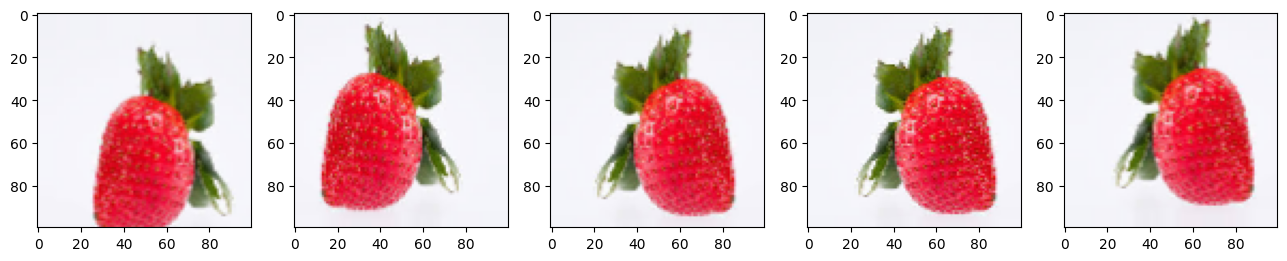

In [12]:
from pathlib import Path

IMG_DIM = (100, 100)

train_files = glob.glob('./o-vs-r-split/train/O/*')
train_files = train_files[:20]
train_imgs = [tf.keras.preprocessing.image.img_to_array(tf.keras.preprocessing.image.load_img(img, target_size=IMG_DIM)) for img in train_files]
train_imgs = np.array(train_imgs)
train_labels = [Path(fn).parent.name for fn in train_files]

img_id = 0
O_generator = train_datagen.flow(train_imgs[img_id:img_id+1], train_labels[img_id:img_id+1],
                                   batch_size=1)
O = [next(O_generator) for i in range(0,5)]
fig, ax = plt.subplots(1,5, figsize=(16, 6))
print('Labels:', [item[1][0] for item in O])
l = [ax[i].imshow(O[i][0][0]) for i in range(0,5)]


In [13]:
from tensorflow.keras.applications import vgg16

input_shape = (150, 150, 3)
vgg = vgg16.VGG16(include_top=False,
                        weights='imagenet',
                        input_shape=input_shape)



In [14]:
output = vgg.layers[-1].output
output = tf.keras.layers.Flatten()(output)
basemodel = Model(vgg.input, output)

In [15]:
for layer in basemodel.layers: 
    layer.trainable = False

In [16]:
input_shape = basemodel.output_shape[1]

model = Sequential()
model.add(basemodel)
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))

In [17]:
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model (Functional)          (None, 8192)              14714688  
                                                                 
 dense (Dense)               (None, 512)               4194816   
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 512)               262656    
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_2 (Dense)             (None, 1)                 513       
                                                                 
Total params: 19172673 (73.14 MB)
Trainable params: 4457

In [19]:
for layer in basemodel.layers: 
    layer.trainable = False
from tensorflow.keras import optimizers

model.compile(
    loss='binary_crossentropy',
    optimizer=optimizers.RMSprop(learning_rate=1e-4),
    metrics=['accuracy']
)


In [20]:
from tensorflow.keras.callbacks import LearningRateScheduler


checkpoint_path='O_R_tlearn_vgg16.keras'

# define step decay function
class LossHistory_(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.lr = []
        
    def on_epoch_end(self, epoch, logs={}):
        self.losses.append(logs.get('loss'))
        self.lr.append(exp_decay(epoch))
        print('lr:', exp_decay(len(self.losses)))

def exp_decay(epoch):
    initial_lrate = 1e-4
    k = 0.1
    lrate = initial_lrate * np.exp(-k*epoch)
    return lrate

# learning schedule callback
loss_history_ = LossHistory_()
lrate_ = LearningRateScheduler(exp_decay)

keras_callbacks = [
      EarlyStopping(monitor = 'val_loss', 
                    patience = 4, 
                    mode = 'min', 
                    min_delta=0.01),
      ModelCheckpoint(checkpoint_path, monitor='val_loss', save_best_only=True, mode='min')
]

callbacks_list_ = [loss_history_, lrate_] + keras_callbacks

In [21]:
extract_feat_model = model.fit(train_generator, 
                               steps_per_epoch=5, 
                               epochs=10,
                               callbacks = callbacks_list_,   
                               validation_data=val_generator, 
                               validation_steps=val_generator.samples // batch_size, 
                               verbose=1)

Epoch 1/10


5/5 [==============================] - 43s 9s/step - loss: 0.7666 - accuracy: 0.5562 - val_loss: 0.5965 - val_accuracy: 0.7083 - lr: 1.0000e-04
Epoch 2/10
5/5 [==============================] - 33s 7s/step - loss: 0.5999 - accuracy: 0.6500 - val_loss: 0.5432 - val_accuracy: 0.6927 - lr: 9.0484e-05
Epoch 3/10
5/5 [==============================] - 41s 9s/step - loss: 0.5437 - accuracy: 0.7063 - val_loss: 0.4721 - val_accuracy: 0.7865 - lr: 8.1873e-05
Epoch 4/10
5/5 [==============================] - 41s 9s/step - loss: 0.4782 - accuracy: 0.7688 - val_loss: 0.4049 - val_accuracy: 0.8594 - lr: 7.4082e-05
Epoch 5/10
5/5 [==============================] - 34s 8s/step - loss: 0.4175 - accuracy: 0.8250 - val_loss: 0.3940 - val_accuracy: 0.8281 - lr: 6.7032e-05
Epoch 6/10
5/5 [==============================] - 41s 10s/step - loss: 0.4924 - accuracy: 0.7812 - val_loss: 0.3929 - val_accuracy: 0.8177 - lr: 6.0653e-05
Epoch 7/10
5/5 [==============================] - 28s 6s/step - los

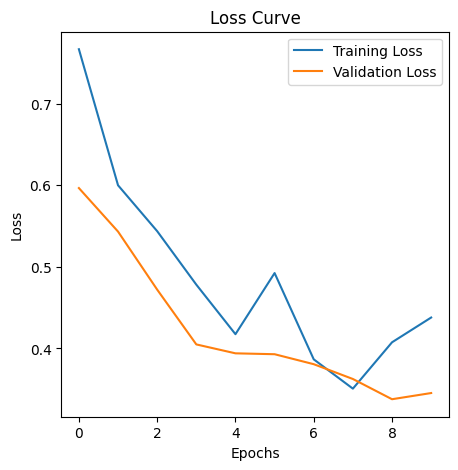

In [23]:
import matplotlib.pyplot as plt

history = extract_feat_model

# plot loss curve
plt.figure(figsize=(5, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

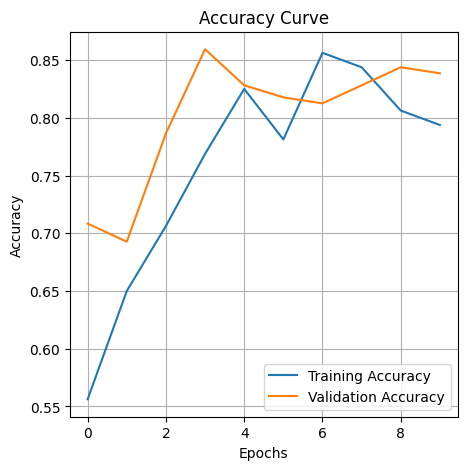

In [24]:
import matplotlib.pyplot as plt

history = extract_feat_model
## Task 6: Plot accuracy curves for training and validation sets
import matplotlib.pyplot as plt

plt.figure(figsize=(5, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Curve')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()



In [25]:
from tensorflow.keras.applications import vgg16

input_shape = (150, 150, 3)
vgg = vgg16.VGG16(include_top=False,
                        weights='imagenet',
                        input_shape=input_shape)

output = vgg.layers[-1].output
output = tf.keras.layers.Flatten()(output)
basemodel = Model(vgg.input, output)

for layer in basemodel.layers: 
    layer.trainable = False

display([layer.name for layer in basemodel.layers])

set_trainable = False

for layer in basemodel.layers:
    if layer.name in ['block5_conv3']:
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

for layer in basemodel.layers:
    print(f"{layer.name}: {layer.trainable}")

['input_2',
 'block1_conv1',
 'block1_conv2',
 'block1_pool',
 'block2_conv1',
 'block2_conv2',
 'block2_pool',
 'block3_conv1',
 'block3_conv2',
 'block3_conv3',
 'block3_pool',
 'block4_conv1',
 'block4_conv2',
 'block4_conv3',
 'block4_pool',
 'block5_conv1',
 'block5_conv2',
 'block5_conv3',
 'block5_pool',
 'flatten_1']

input_2: False
block1_conv1: False
block1_conv2: False
block1_pool: False
block2_conv1: False
block2_conv2: False
block2_pool: False
block3_conv1: False
block3_conv2: False
block3_conv3: False
block3_pool: False
block4_conv1: False
block4_conv2: False
block4_conv3: False
block4_pool: False
block5_conv1: False
block5_conv2: False
block5_conv3: True
block5_pool: True
flatten_1: True


In [26]:
model = Sequential()
model.add(basemodel)
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))

checkpoint_path='O_R_tlearn_fine_tune_vgg16.keras'

# learning schedule callback
loss_history_ = LossHistory_()
lrate_ = LearningRateScheduler(exp_decay)

keras_callbacks = [
      EarlyStopping(monitor = 'val_loss', 
                    patience = 4, 
                    mode = 'min', 
                    min_delta=0.01),
      ModelCheckpoint(checkpoint_path, monitor='val_loss', save_best_only=True, mode='min')
]

callbacks_list_ = [loss_history_, lrate_] + keras_callbacks

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(learning_rate=1e-4),
              metrics=['accuracy'])

fine_tune_model = model.fit(train_generator, 
                    steps_per_epoch=5, 
                    epochs=10,
                    callbacks = callbacks_list_,   
                    validation_data=val_generator, 
                    validation_steps=val_generator.samples // batch_size, 
                    verbose=1)

Epoch 1/10
5/5 [==============================] - 33s 7s/step - loss: 0.8392 - accuracy: 0.5063 - val_loss: 0.5498 - val_accuracy: 0.7969 - lr: 1.0000e-04
Epoch 2/10
5/5 [==============================] - 30s 7s/step - loss: 0.5537 - accuracy: 0.7000 - val_loss: 0.4604 - val_accuracy: 0.8333 - lr: 9.0484e-05
Epoch 3/10
5/5 [==============================] - 29s 7s/step - loss: 0.4540 - accuracy: 0.8000 - val_loss: 0.4364 - val_accuracy: 0.7969 - lr: 8.1873e-05
Epoch 4/10
5/5 [==============================] - 47s 11s/step - loss: 0.4892 - accuracy: 0.7625 - val_loss: 0.3914 - val_accuracy: 0.8281 - lr: 7.4082e-05
Epoch 5/10
5/5 [==============================] - 40s 9s/step - loss: 0.4122 - accuracy: 0.8313 - val_loss: 0.3641 - val_accuracy: 0.8385 - lr: 6.7032e-05
Epoch 6/10
5/5 [==============================] - 37s 8s/step - loss: 0.3325 - accuracy: 0.8813 - val_loss: 0.3826 - val_accuracy: 0.8177 - lr: 6.0653e-05
Epoch 7/10
5/5 [==============================] - 35s 8s/step - loss:

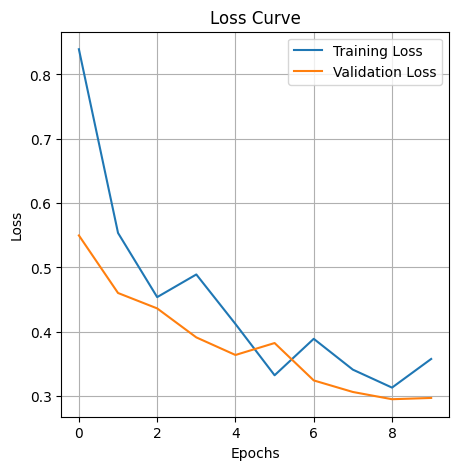

In [27]:
history = fine_tune_model

## Task 7: Plot loss curves for training and validation sets (fine tune model)
import matplotlib.pyplot as plt

history = fine_tune_model  # Make sure this variable stores the history from fine-tuning

plt.figure(figsize=(5, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


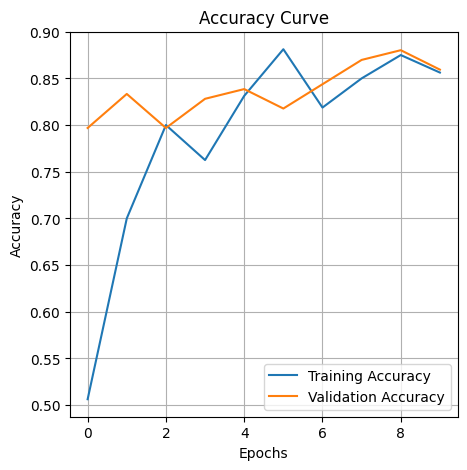

In [28]:
history = fine_tune_model

# Task 8: Plot accuracy curves for training and validation sets  (fine tune model)
import matplotlib.pyplot as plt

history = fine_tune_model  # Make sure this variable stores the fine-tuning history

plt.figure(figsize=(5, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Curve')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()


In [29]:
from pathlib import Path

# Load saved models
extract_feat_model = tf.keras.models.load_model('O_R_tlearn_vgg16.keras')
fine_tune_model = tf.keras.models.load_model('O_R_tlearn_fine_tune_vgg16.keras')

IMG_DIM = (150, 150)

# Load test images
test_files_O = glob.glob('./o-vs-r-split/test/O/*')
test_files_R = glob.glob('./o-vs-r-split/test/R/*')
test_files = test_files_O[:50] + test_files_R[:50]

test_imgs = [tf.keras.preprocessing.image.img_to_array(tf.keras.preprocessing.image.load_img(img, target_size=IMG_DIM)) for img in test_files]
test_imgs = np.array(test_imgs)
test_labels = [Path(fn).parent.name for fn in test_files]

# Standardize
test_imgs_scaled = test_imgs.astype('float32')
test_imgs_scaled /= 255

class2num_lt = lambda l: [0 if x == 'O' else 1 for x in l]
num2class_lt = lambda l: ['O' if x < 0.5 else 'R' for x in l]

test_labels_enc = class2num_lt(test_labels)

# Make predictions for both models
predictions_extract_feat_model = extract_feat_model.predict(test_imgs_scaled, verbose=0)
predictions_fine_tune_model = fine_tune_model.predict(test_imgs_scaled, verbose=0)

# Convert predictions to class labels
predictions_extract_feat_model = num2class_lt(predictions_extract_feat_model)
predictions_fine_tune_model = num2class_lt(predictions_fine_tune_model)

# Print classification report for both models
print('Extract Features Model')
print(metrics.classification_report(test_labels, predictions_extract_feat_model))
print('Fine-Tuned Model')
print(metrics.classification_report(test_labels, predictions_fine_tune_model))


Extract Features Model
              precision    recall  f1-score   support

           O       0.73      0.88      0.80        50
           R       0.85      0.68      0.76        50

    accuracy                           0.78       100
   macro avg       0.79      0.78      0.78       100
weighted avg       0.79      0.78      0.78       100

Fine-Tuned Model
              precision    recall  f1-score   support

           O       0.75      0.80      0.78        50
           R       0.79      0.74      0.76        50

    accuracy                           0.77       100
   macro avg       0.77      0.77      0.77       100
weighted avg       0.77      0.77      0.77       100



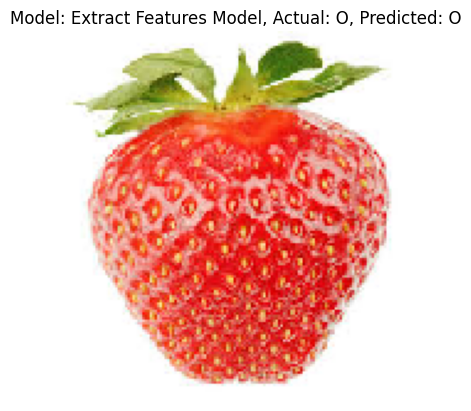

In [30]:
# Plot one of the images with actual label and predicted label as title
def plot_image_with_title(image, model_name, actual_label, predicted_label):
    plt.imshow(image)
    plt.title(f"Model: {model_name}, Actual: {actual_label}, Predicted: {predicted_label}")
    plt.axis('off')
    plt.show()

# Specify index of image to plot, for example index 0
index_to_plot = 0
plot_image_with_title(
    image=test_imgs[index_to_plot].astype('uint8'),
    model_name='Extract Features Model',
    actual_label=test_labels[index_to_plot], 
    predicted_label=predictions_extract_feat_model[index_to_plot],
    )

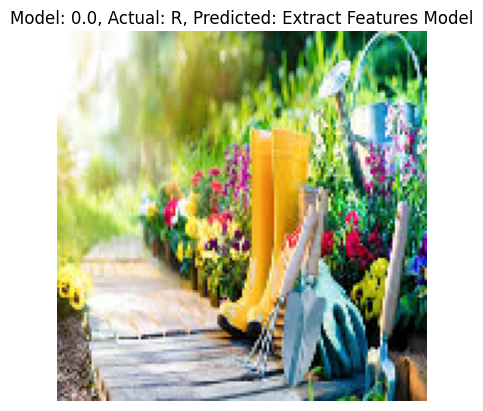

In [31]:
index_to_plot = 1
model_name = 'Extract Features Model'

# Load image and true label from test generator
image_batch, label_batch = next(test_generator)
img = image_batch[index_to_plot]
true_label = label_batch[index_to_plot]

# Get predicted label from your extract features model prediction array
predicted_label = predictions_extract_feat_model[index_to_plot]

# Plot using the helper function
plot_image_with_title(img, true_label, predicted_label, model_name)


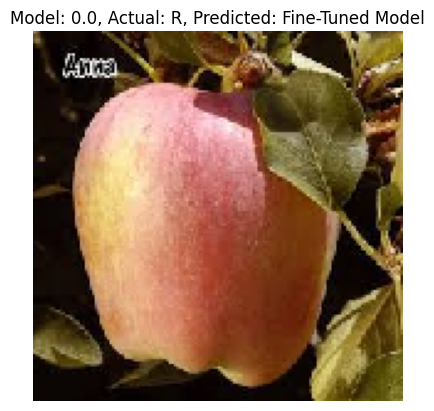

In [33]:
index_to_plot = 1
model_name = 'Fine-Tuned Model'

# Get the image and true label from the test generator
image_batch, label_batch = next(test_generator)
img = image_batch[index_to_plot]
true_label = label_batch[index_to_plot]

# Get the predicted label from the fine-tuned model predictions
predicted_label = predictions_fine_tune_model[index_to_plot]

# Use the helper function to plot the image
plot_image_with_title(img, true_label, predicted_label, model_name)
